# Bayes rule for 2-D Gaussians

The following demo is provided by courtesy of Kevin Murphy and is based on Sec.4.4.2.2 of his book (Murphy, 2012; ["Machine Learning - A Probabilistic Perspective"](https://www.cs.ubc.ca/~murphyk/MLbook/)).

We are interested in estimating a posterior belief over a latent variable `x` from observations `y=y_hat` following the 2-dimensional Gaussian linear model

\begin{align*}
    x &\sim \mathcal{N}(\mu_x, \Sigma_x)\\
    y_i &\sim \mathcal{N}(Ax + b, \Sigma_y)\,.
\end{align*}

In [15]:
using ForneyLab
using LinearAlgebra
using Random
import Distributions: pdf, MvNormal, rand

Random.seed!(1) # Set random seed

n = 100 # Number of datapoints

# Data
true_x = [0.5, 0.5] # True value for latent variable x
A = diageye(2) # diageye returns an identity matrix of type Diagonal
b = zeros(2)
Sigma_y = 0.1*[2 1; 1 1] # Observation covariance

y_hat_mat = rand(MvNormal(A*true_x + b, Sigma_y), n)' # Data matrix
y_hat = [y_hat_mat[i,:] for i=1:n] # Unfold data matrix in a vector of vectors
;

## Model specification

In [16]:
g = FactorGraph() # Initiate a new factor graph

# Model
@RV x ~ GaussianMeanVariance(
          placeholder(:mu_x, dims=(2,)), 
          placeholder(:Sigma_x, dims=(2,2))) # Prior with placeholders for statistics
@RV y ~ GaussianMeanVariance(A*x + b, Sigma_y) # Likelihood

placeholder(y, :y, dims=(2,)) # Indicate observed variable; dims indicates the dimensionality of the data
;

## Algorithm generation

In [17]:
algo = sumProductAlgorithm(x) # Generate algorithm
eval(Meta.parse(algo)) # Load algorithm

println(algo) # Inspect the algorithm

begin

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 4))

messages[1] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(Multivariate, PointMass, m=data[:mu_x]), Message(MatrixVariate, PointMass, m=data[:Sigma_x]))
messages[2] = ruleSPGaussianMeanVarianceMPNP(Message(Multivariate, PointMass, m=data[:y]), nothing, Message(MatrixVariate, PointMass, m=[0.2 0.1; 0.1 0.1]))
messages[3] = ruleSPAdditionIn1GNP(messages[2], nothing, Message(Multivariate, PointMass, m=[0.0, 0.0]))
messages[4] = ruleSPMultiplicationIn1GNP(messages[3], nothing, Message(MatrixVariate, PointMass, m=Diagonal([1.0, 1.0])))

marginals[:x] = messages[1].dist * messages[4].dist

return marginals

end

end # block


## Algorithm execution

In [18]:
# Prior statistics
mu_x_0 = zeros(2)
Sigma_x_0 = 0.1*diageye(2)

# Perform inference
mu_x = deepcopy(mu_x_0)
Sigma_x = deepcopy(Sigma_x_0)
for i = 1:n
    data = Dict(:mu_x => mu_x,
                :Sigma_x => Sigma_x,
                :y => y_hat[i]) # Prepare dictionary with prior statistics and present datapoint
    
    marginals = step!(data) # Execute the algorithm
    
    # Today's posterior is tomorrow's prior
    mu_x = mean(marginals[:x])
    Sigma_x = cov(marginals[:x])
end
;

## Results

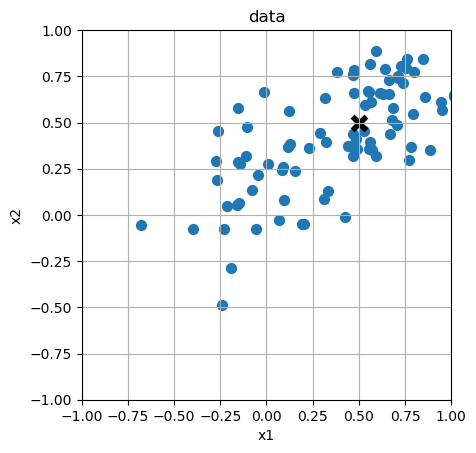

In [19]:
using PyPlot

# Plot data
scatter(y_hat_mat[:,1], y_hat_mat[:,2], label="obs", s=50)
scatter(true_x[1], true_x[2], marker="x", color="black", s=100, lw=4)
title("data")
grid("on")
axis("square")
xlim(-1.0, 1.0)
ylim(-1.0, 1.0)
xlabel("x1")
ylabel("x2")
;

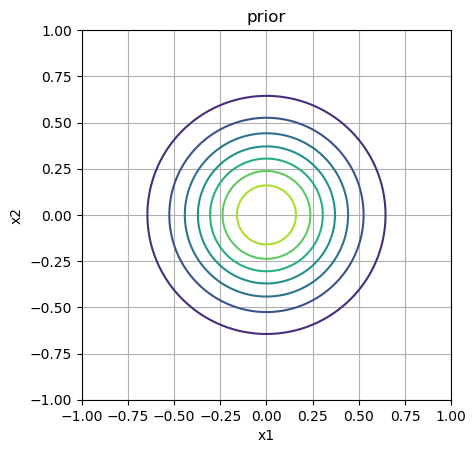

In [20]:
# Prepare plotting grids
k = 100
x1 = x2 = range(-1.0, 1.0, length=100)
x1_grid = repeat(x1', k, 1)
x2_grid = repeat(x2, 1, k)

z_prior = zeros(k,k)
z_posterior = zeros(k,k)
for i in 1:k
    for j in 1:k
        z_prior[i,j] = pdf(MvNormal(mu_x_0, Sigma_x_0), [x1[i], x2[j]])
        z_posterior[i,j] = pdf(MvNormal(mu_x, Sigma_x), [x1[i], x2[j]])
    end
end

# Plot prior
contour(x1_grid, x2_grid, z_prior)
title("prior")
grid("on")
axis("square")
xlabel("x1")
ylabel("x2")
;

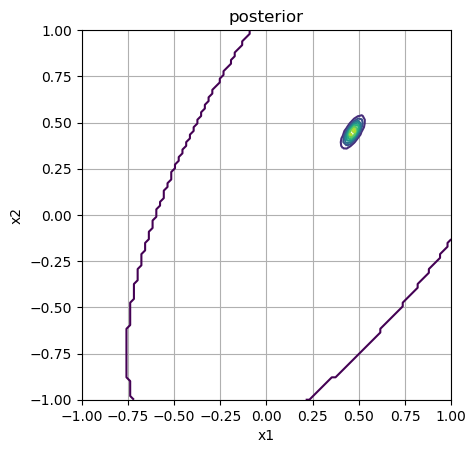

In [21]:
# Plot posterior
contour(x1_grid, x2_grid, z_posterior)
title("posterior")
grid("on")
axis("square")
xlabel("x1")
ylabel("x2")
;